## File to allocate population
Jameson Carter

purpose: To distribute the entire population into residential buildings according to the average household size in tracts.

input: relevant_buildings.shp
       sourced from '2- Generate spatial dataset.ipynb' and ACSData.csv sourced from '3- getPopulation.py'
       
output: relevant_buildings_populated.shp

#### 1. Import buildings and population data

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt

In [2]:
buildings = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/relevant_buildings.shp')

In [3]:
population = pd.read_csv('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processing_code/ACSData.csv')

In [4]:
buildings['class_reco'].unique()

array(['1-Unit Residential', '2-Unit Residential', 'commercial',
       'Grocery Store', '4+ Unit Residential', '3-Unit Residential'],
      dtype=object)

In [5]:
population['geometry'] = population['geometry'].apply(wkt.loads) # get population geometries
geo_population = gpd.GeoDataFrame(population, geometry = 'geometry').set_crs(buildings.crs) # turn into polygons
# Write file to the processed data
geo_population.to_file("C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/ACS_geo.shp")

C:\Users\jacar\AppData\Roaming\Python\Python38\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\jacar\AppData\Local\Temp\ipykernel_38384\2457771380.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_population.to_file("C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/ACS_geo.shp")


In [6]:
# copy GeoDataFrame, because ACS polygons don't align perfectly
building_points = buildings.copy()
# change geometry to a plane area rather than geodic: https://stackoverflow.com/questions/63004400/getting-a-userwarning-when-calculating-centroid-of-a-geoseries
building_points['geometry'] = building_points['geometry'].to_crs(epsg=3035).centroid
# Now we reset points to original CRS, so they are consistent
building_points = building_points.to_crs(buildings.crs)

In [7]:
population

,Unnamed: 0,geo_id,B01003_001E,B25010_001E,geometry
0,0,1400000US42003010301,2477.0,NaN,"MULTIPOLYGON (((-79.99591 40.43389, -79.99572 ..."
1,1,1400000US42003010302,4101.0,1.96,"MULTIPOLYGON (((-79.99387 40.43851, -79.99371 ..."
2,2,1400000US42003020100,4654.0,1.49,"MULTIPOLYGON (((-80.01538 40.44308, -80.00932 ..."
3,3,1400000US42003020300,1368.0,1.38,"MULTIPOLYGON (((-79.99613 40.44818, -79.99240 ..."
4,4,1400000US42003030500,2655.0,1.69,"MULTIPOLYGON (((-79.99298 40.44036, -79.99228 ..."
...,...,...,...,...,...
389,389,1400000US42003981000,0.0,NaN,"MULTIPOLYGON (((-79.95762 40.47613, -79.95570 ..."
390,390,1400000US42003981100,0.0,NaN,"MULTIPOLYGON (((-79.91258 40.44111, -79.91225 ..."
391,391,1400000US42003981200,0.0,NaN,"MULTIPOLYGON (((-80.01807 40.44888, -80.01504 ..."
392,392,1400000US42003981800,434.0,NaN,"MULTIPOLYGON (((-79.90784 40.47965, -79.90784 ..."


In [8]:
building_points.crs == geo_population.crs

True

<AxesSubplot:>

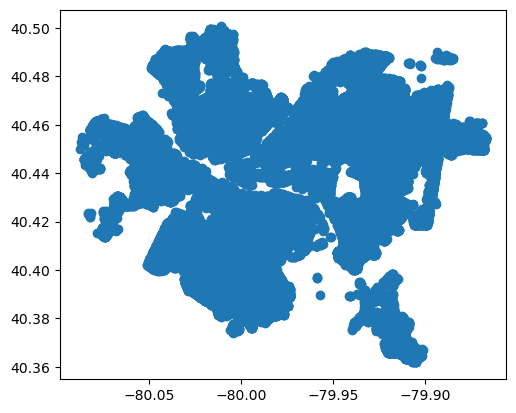

In [9]:
merge = building_points.sjoin(geo_population, how='inner')
merge.plot()

In [10]:
# NEED TO EXTRACT CENSUS TRACT DESIGNATION
# The Census tract variable tractce10 from WPRDC is wrong, need to extract secondhand from the ACSData file
merge['tract_id'] = merge['geo_id'].str[-6:]

#### 2. Method 1, distribute population simply based on estimated household size times number of units
This method appears to display some inconsistencies, population does not 'add up' well to the population reported by ACS. See below...

In [11]:
merge['estimated_hh'] = 0 # baseline is nobody lives in a building
# Code according to number of units in a building
merge.loc[merge['class_reco'] == '1-Unit Residential', 'estimated_hh'] = 1
merge.loc[merge['class_reco'] == '2-Unit Residential', 'estimated_hh'] = 2
merge.loc[merge['class_reco'] == '3-Unit Residential', 'estimated_hh'] = 3
merge.loc[merge['class_reco'] == '4+ Unit Residential', 'estimated_hh'] = 4
merge['estimated_hh'] = merge['estimated_hh']*merge['B25010_001E'] # Get total estimate
population_est = merge.groupby('tract_id')['estimated_hh'].sum()
population_true = merge.groupby('tract_id')['B01003_001E'].unique()
population_true
target_tracts = pd.concat([population_est, population_true], axis=1)
target_tracts = target_tracts.reset_index(level=0)
lowaccess = target_tracts.loc[target_tracts['tract_id'].isin(['260200','260900','561900','562300',
                                                  '562800','120300','320400','262000',
                                                  '562600','562900','290400'])] #260900 missing, 562900

In [12]:
lowaccess

,tract_id,estimated_hh,B01003_001E
40,120300,9080.50,[2050.0]
78,260200,2376.15,[2157.0]
83,262000,2332.80,[2505.0]
92,290400,5230.89,[4173.0]
95,320400,1856.58,[1814.0]
124,561900,3917.30,[2050.0]
126,562300,2967.92,[2656.0]
129,562600,2716.56,[2624.0]
131,562800,1911.76,[1415.0]


In [13]:
merge['tract_id'].unique()

array(['191800', '479000', '320700', '320600', '470502', '562800',
       '469000', '563000', '464300', '202300', '473100', '480300',
       '290400', '320400', '290200', '478100', '472100', '192000',
       '476200', '477200', '290100', '191900', '191700', '488500',
       '310200', '488300', '484500', '160900', '161000', '480400',
       '565300', '562901', '481000', '160800', '523100', '561900',
       '981800', '130700', '560500', '515401', '141200', '482500',
       '141100', '130600', '560400', '981100', '140500', '428100',
       '241300', '428200', '262000', '429700', '260200', '980400',
       '261300', '429100', '270800', '271600', '270100', '270300',
       '260700', '261500', '980900', '261400', '250900', '060300',
       '090100', '981000', '110200', '980100', '090200', '101400',
       '101800', '110600', '101100', '100500', '120300', '111300',
       '980000', '421100', '101900', '180300', '170600', '191400',
       '020100', '030500', '191100', '300100', '562500', '5651

In [14]:
food_apartheid = merge.loc[(merge['tract_id'].isin(['260200','561900','562300',
                                                  '562800','120300','320400','262000',
                                                  '562600','562900','290400']))&
                                                  ~(merge['class_reco'].isin(['Grocery Store', 'commercial']))]

food_apartheid['hood'].unique()

array(['Oakwood', 'Carrick', 'Overbrook', 'Lincoln-Lemington-Belmar',
       'Spring Garden', 'Spring Hill-City View', 'East Allegheny',
       'Perry North', 'Crafton Heights', 'Elliott', 'Hazelwood',
       'Squirrel Hill South'], dtype=object)

### Getting estimates of population
The following code estimates population outright assuming all buildings are occupied, and have the occupancy of the average * our estimates of their numbers of units. This will be imperfect and will show issues for some neighborhoods where zoning does not reflect the qualities of the buildings. For instance, one neighborhood is zoned as multifamily which almost certainly has mostly single family homes (or a lot of abandoned ones).

In [38]:
merge.loc[merge['class_reco'] == '1-Unit Residential', 'estimated_hh'] = 1
merge.loc[merge['class_reco'] == '2-Unit Residential', 'estimated_hh'] = 2
merge.loc[merge['class_reco'] == '3-Unit Residential', 'estimated_hh'] = 3
merge.loc[merge['class_reco'] == '4+ Unit Residential', 'estimated_hh'] = 4

merge['estimated_hh'] = merge['estimated_hh']*merge['B25010_001E']
merge.loc[merge['estimated_hh'].isna() & (merge['tract_id'].isin(['260200','561900','562300',
                                                  '562800','120300','320400','262000',
                                                  '562600','562900','290400'])) ] # None of the coerced NAs are relevant to our analysis!

,CLASS,class_reco,hood,geoid10,tractce10,geometry,index_right,Unnamed: 0,geo_id,B01003_001E,B25010_001E,tract_id,estimated_hh


In [39]:
# Final dataset
merge

,CLASS,class_reco,hood,geoid10,tractce10,geometry,index_right,Unnamed: 0,geo_id,B01003_001E,B25010_001E,tract_id,estimated_hh
0,C,1-Unit Residential,Brookline,420031918003,191800,POINT (-80.01241 40.38317),71,71,1400000US42003191800,5032.0,2.16,191800,2.16
1,R,1-Unit Residential,Brookline,420031918003,191800,POINT (-80.01375 40.38637),71,71,1400000US42003191800,5032.0,2.16,191800,2.16
5,R,1-Unit Residential,Brookline,420031918003,191800,POINT (-80.01242 40.38299),71,71,1400000US42003191800,5032.0,2.16,191800,2.16
7,R,1-Unit Residential,Brookline,420031918003,191800,POINT (-80.01013 40.38940),71,71,1400000US42003191800,5032.0,2.16,191800,2.16
8,R,1-Unit Residential,Brookline,420031918003,191800,POINT (-80.00998 40.39113),71,71,1400000US42003191800,5032.0,2.16,191800,2.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116209,C,commercial,North Oakland,420030404001,040400,POINT (-79.95076 40.44948),6,6,1400000US42003040400,1650.0,1.46,040400,0.00
116210,C,commercial,North Oakland,420030404001,040400,POINT (-79.94834 40.44626),6,6,1400000US42003040400,1650.0,1.46,040400,0.00
116211,C,4+ Unit Residential,North Oakland,420030404001,040400,POINT (-79.94828 40.44744),6,6,1400000US42003040400,1650.0,1.46,040400,5.84
116212,None,4+ Unit Residential,North Oakland,420030404001,040400,POINT (-79.95091 40.44820),6,6,1400000US42003040400,1650.0,1.46,040400,5.84
